In [6]:
import numpy as np
import pickle
from matplotlib import pyplot as plt
import matplotlib

def conf_intervals(x,n_train,epochs):
    #Returns per-epoch mean rewards/costs as well as lower and upper bounds assuming normally distributed errors
    #given a list of rewards or cost of length n_train*epochs. If the list is shorter, outputs are filled by NaNs. 
    means = []
    lows = []
    highs = []
    for i in range(len(x)//n_train):
        means.append(np.mean(x[i*n_train:(i+1)*n_train]))
        lows.append(means[i]-1.645*np.std(x[i*n_train:(i+1)*n_train])/np.sqrt(n_train))
        highs.append(means[i]+1.645*np.std(x[i*n_train:(i+1)*n_train])/np.sqrt(n_train))
    while len(means)<epochs:
        means.append(np.nan)
        lows.append(np.nan)
        highs.append(np.nan)
    return np.array(means), np.array(lows), np.array(highs)



def plot(files,legend=[],loc_legend="lower left",epochs=10,fig_legend=2,stretch=1,figsize=(10,3),fontsize=10):
    #Plots costs and rewards. Files is a list of the experiment names stored in the corresponding ...+"costs.pkl" 
    #and ...+"rews.pkl" files in the results folder. 
    #Legend lists the names used for the legend in the same order.
    #Epochs is the maximal amount of training epochs for the experiments (all epochs are 25 episodes). 
    #Fig_legend determines whether the legend is displayed in the cost- or reward-subfigure.
    #Stretch can be used to calculate means and confidence intervals using more than one epoch 
    #(useful for longer experiments). 
    #Figsize determines the overall figure size.
    #Fontsize determines the fontsize used for all text in the plots (legend, axis labels and ticks)
    
    matplotlib.rcParams.update({'font.size': fontsize})
    colors = ["orange","blue","red","green","purple"]
    f, (ax1, ax2) = plt.subplots(1, 2,figsize=figsize)
    
    for color,file in zip(colors[:len(files)],files): 
        #load results
        with open("results/"+file+"costs.pkl", "rb") as input_file:
            costs = pickle.load(input_file)
        with open("results/"+file+"rews.pkl", "rb") as input_file:
            rewards = pickle.load(input_file)
        assert file[:3] in ["ppo","sac","td3"]

        #Create lists for train and test episodes. 
        r_train = []
        r_test = []
        c_train = []
        c_test = []
        
        n_train = 25
        if file[:3]=="sac" or file[:3]=="td3":
            n_test = 25
            #only sac and td3 use test episodes
            elif len(rewards) == 350:
                n_test = 10
            #some earlier experiments accidentally used 10 instead of 25 episodes. Adjust accordingly.
            elif len(rewards) == 510:
                n_test = 26
            #Similarly, some earlier experiments had an additional environment reset after the test episodes.
            #Don't include this in the training results. 

        else:
            n_train = 25
            n_test = 0
        #write train and test results to the corresponding lists
        for i in range(epochs):
            r_train += rewards[(n_train+n_test)*i:(n_train+n_test)*(i+1)-n_test]
            c_train += costs[(n_train+n_test)*i:(n_train+n_test)*(i+1)-n_test]
            if file[:3]=="sac" or file[:3]=="td3":
                r_test += rewards[(n_train+n_test)*i+n_train:(n_train+n_test)*(i+1)]
                c_test += costs[(n_train+n_test)*i+n_train:(n_train+n_test)*(i+1)]
                
        #Create confidence intervals
        avr_train,lowerr_train,upperr_train = conf_intervals(r_train,n_train*stretch,epochs/stretch)
        avc_train,lowerc_train,upperc_train = conf_intervals(c_train,n_train*stretch,epochs/stretch)
        
        #Set axis labels 
        ax1.set_xlabel("Environment interactions")
        ax2.set_xlabel("Environment interactions")
        ax1.set_ylabel("Episode reward")
        ax2.set_ylabel("Episode cost")
        
        #Make sure plots use the same scale
        ax1.set_ylim((-5,35))
        
        #Plot rewards
        x = np.arange(epochs/stretch)*1000*n_train*stretch
        ax1.plot(x,avr_train,color=color)
        ax1.fill_between(x,lowerr_train,upperr_train,alpha=1/2,color=color, label='_nolegend_')
        #Include TRPO results 
        if file.split("_")[-1] not in ["cargoal","pointpush","pointgoal2"]:
            ax1.plot(x,np.zeros(len(x))+2.38398003623805,linestyle="dotted",color="grey", label='_nolegend_')
            ax1.plot(x,np.zeros(len(x))+6.122558633103186 ,linestyle="dashdot",color="grey", label='_nolegend_')
            ax1.plot(x,np.zeros(len(x))+9.407788493971768 ,linestyle="dashed",color="grey", label='_nolegend_')
            ax1.plot(x,np.zeros(len(x))+17.146432761106485,color="grey", label='_nolegend_')
            if max(x)>=100000:
                ax1.scatter(100000,2.38398003623805,marker="x",color="grey", label='_nolegend_')
            if max(x)>=500000:
                ax1.scatter(500000,6.122558633103186,marker="x",color="grey", label='_nolegend_')
            if max(x)>=1000000:
                ax1.scatter(1000000,9.407788493971768,marker="x",color="grey", label='_nolegend_')
            if max(x)>=10000000:
                ax1.scatter(10000000,17.146432761106485,marker="x",color="grey", label='_nolegend_')
        
        
        #Make sure plots use the same scale
        ax2.set_ylim((-1,50))
        
        #Plot costs
        ax2.plot(x,avc_train,color=color)
        ax2.fill_between(x,lowerc_train,upperc_train,alpha=1/2,color=color, label='_nolegend_')
        ax2.plot(x,np.zeros(int(epochs/stretch))+25,color="k", label='_nolegend_')
        
        #Include TRPO results
        if file.split("_")[-1] not in ["cargoal","pointpush","pointgoal2"]:
            ax2.plot(x,np.zeros(len(x))+32.517591154162474,linestyle="dotted",color="grey", label='_nolegend_')
            ax2.plot(x,np.zeros(len(x))+28.651618995400412 ,linestyle="dashdot",color="grey", label='_nolegend_')
            ax2.plot(x,np.zeros(len(x))+21.432270248865336 ,linestyle="dashed",color="grey", label='_nolegend_')
            ax2.plot(x,np.zeros(len(x))+25.806451612903246,color="grey", label='_nolegend_')
            if max(x)>=100000:
                ax2.scatter(100000,32.517591154162474,marker="x",color="grey", label='_nolegend_')
            if max(x)>=500000:
                ax2.scatter(500000,28.651618995400412,marker="x",color="grey", label='_nolegend_')
            if max(x)>=1000000:
                ax2.scatter(1000000,21.432270248865336,marker="x",color="grey", label='_nolegend_')
            if max(x)>=10000000:
                ax2.scatter(10000000,25.806451612903246,marker="x",color="grey", label='_nolegend_')
        #Add legend
        if fig_legend==2:
            ax2.legend(legend, loc=loc_legend)
        else:
            ax1.legend(legend, loc=loc_legend)
        
        print("rews",avr_train)
        print("costs",avc_train)
        print(np.mean(avr_train[-1:]))
        print(np.mean(avc_train[-1:]))

[-0.06136308  0.54982024 -0.64362656  0.45274628  0.44976719  0.65513923
  0.45107254  0.61803567  0.56871464  0.70026898]
[36.64 72.96 41.48 60.16 22.52 26.56 75.8  39.84 83.72 71.04]
0.7002689783271785
71.04
[-0.00215293  0.16295968 -0.20546624 -0.18262352  0.62548166  0.77767942
  0.67946956  0.67164754  0.91647191  0.47858596]
[ 49.8   43.72  91.16  46.36  78.16 117.48  44.48  42.52  85.52  62.76]
0.4785859625181281
62.76
[ 9.0783072  21.94589046 26.04303832 26.62726086 27.34847546 26.40555179
 27.37454229 27.70248598 27.45595719 28.17364192]
[38.24 62.76 46.44 49.04 48.72 46.64 41.72 44.   47.84 52.6 ]
28.17364192491767
52.6
[-0.20795986  0.74233949  0.6964814   0.8470356  23.51894026 27.37606239
 27.26428241 26.76115519 27.89283893 27.45231457]
[52.6  28.88 29.36 16.92 46.92 67.24 54.16 52.28 51.52 46.36]
27.4523145730058
46.36


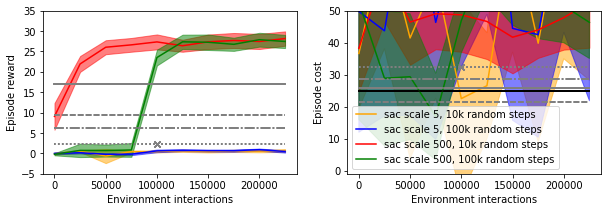

In [6]:
plot(["sac_a02_ss10k","sac_a02_ss100k","sac_a0002_ss10k","sac_a0002_ss100k"],legend=["sac scale 5, 10k random steps","sac scale 5, 100k random steps","sac scale 500, 10k random steps","sac scale 500, 100k random steps"],loc_legend="lower left")
plt.show()

19.06018202724745
59.68
18.694732671260294
53.92
19.436337549056095
50.64
19.01154333605747
50.84


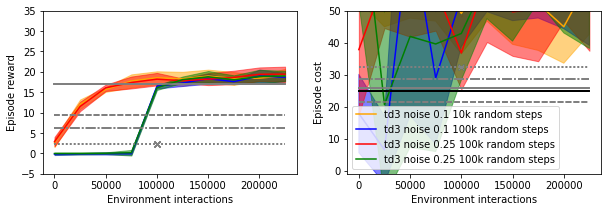

In [245]:
plot(["td3_an01_ss10k","td3_an01_ss100k","td3_an025_ss10k","td3_an025_ss100k"],legend=["td3 noise 0.1 10k random steps","td3 noise 0.1 100k random steps","td3 noise 0.25 100k random steps","td3 noise 0.25 100k random steps"])

plt.show()

27.945895535079813
52.56
27.950825562576775
55.4


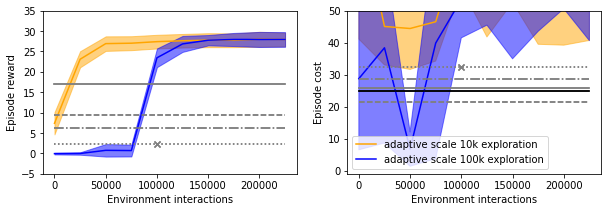

In [246]:
plot(["sac_c_ss10k","sac_c_ss100k"],legend=["adaptive scale 10k exploration","adaptive scale 100k exploration"])
plt.show()

34.87530532543697
57.12
0.7659213367085544
27.24
24.738418501745276
170.92


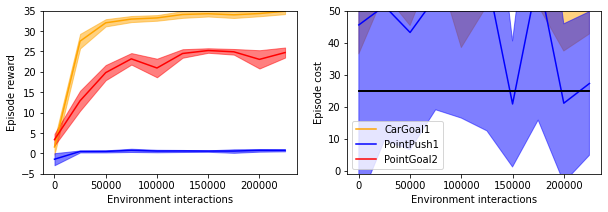

In [247]:
plot(["sac_c_ss10k_cargoal","sac_c_ss10k_pointpush","sac_c_ss10k_pointgoal2"])

plt.legend(["CarGoal1","PointPush1","PointGoal2"])
plt.show()

27.945895535079813
52.56
12.844824583751834
44.0
14.635156307308348
36.16
7.975508501097538
32.56
4.226092126004631
20.68


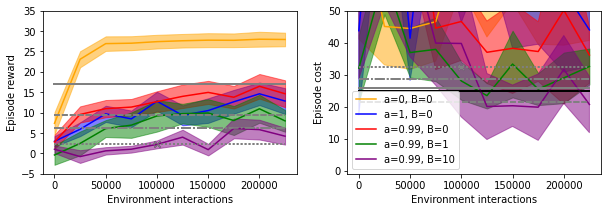

In [248]:
plot(["sac_c_ss10k","sac_c_ss10k_m0","sac_c_ss10k_m001","sac_c_ss10k_m001_a1","sac_c_ss10k_m001_a10"],["a=0, B=0","a=1, B=0","a=0.99, B=0","a=0.99, B=1","a=0.99, B=10"])

plt.show()

rews [ 8.22465736 22.70125724 22.69839352 25.93963079 26.47058289 26.41452351
 27.24290749 26.88812497 26.9020093  27.21255846 27.10167084 26.94388971
 26.97930002 27.22845128 27.10437652 26.98977617 27.1714103  26.97219582
 27.58989129 27.53803175]
costs [28.84 48.04 62.   48.72 57.8  45.08 61.52 53.56 42.48 44.08 57.92 41.12
 42.   58.64 54.84 56.68 60.76 51.2  32.64 56.16]
27.5380317490419
56.16
rews [ 3.60055551 14.04125332  6.74172009 12.23141989 14.40968583 12.99279607
 11.94509735 16.09479084 13.71451542 15.26385105 12.57667481 18.75191119
 16.06555526 14.44960184 17.42617381 16.02152294 14.97484487 20.48761611
 21.61209076 16.74269546]
costs [ 60.76  59.16 124.48  52.04  92.68  78.76  48.76  67.36  94.76  73.72
  39.   103.36  40.72  37.56  44.88  60.76  36.96  47.96  36.68  29.16]
16.74269546001842
29.16
rews [ 1.76984005  6.14303483  6.26340714  8.04508834  6.44315297  8.75089494
  7.92154768  7.45244498  6.03199597  9.9779618   9.15039177 10.79297254
 10.03360588  9.08050424

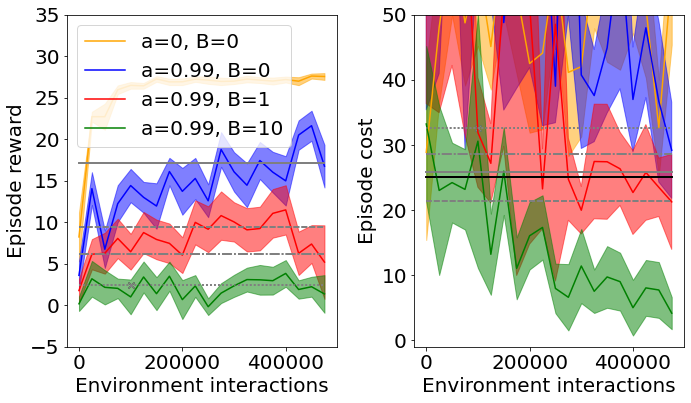

In [24]:
plot(["sac_c_ss10k_long","sac_c_ss10k_m001_long","sac_c_ss10k_m001_a1_long","sac_c_ss10k_m001_a10_long"],["a=0, B=0","a=0.99, B=0","a=0.99, B=1","a=0.99, B=10"],epochs=20,fig_legend=1,figsize=(10,6),fontsize=20,loc_legend="upper left")
# We left out a=0.1 as results look very similar to a=0.99 and the plot is a bit crowded ("sac_c_ss10k_m0_long")
plt.tight_layout()
plt.show()

rews [ 2.55455387 12.05647368 15.68313576 17.7646435  18.55528119 18.29349422
 18.99051309 18.38292577 18.46898885 19.06018203]
costs [101.8   61.08  65.8   62.08  49.16  61.72  53.24  52.24  45.    59.68]
19.06018202724745
59.68
rews [ 3.34984986  6.07451088 10.01869613 14.0462154  13.9186247  14.31744126
 13.40741886 18.87958873 19.19959595 16.2425255 ]
costs [ 63.88  92.08  51.68  33.36  43.44  52.24  43.6   90.64  75.84 105.28]
16.24252549833541
105.28
rews [ 2.68843756  7.36021474  8.84245707 14.05134004  7.22448207 14.14988822
 14.3009044  12.43503495 12.51101504  7.14172966]
costs [56.52 64.64 32.88 46.6  41.52 39.16 38.52 50.68 38.08 40.24]
7.141729658062901
40.24
rews [ 2.50109377  8.77109458  8.81825717 10.79006501  8.65017643  8.48326187
 10.44431944  9.97769217  8.92339121 10.88574451]
costs [ 44.2  102.36  96.36  61.24  53.44  39.32  37.6  101.92  79.32  18.4 ]
10.88574450683837
18.4
rews [-1.54574015 -1.98262946  0.06390323  0.71591117  0.70970917  0.17839574
  0.25101377

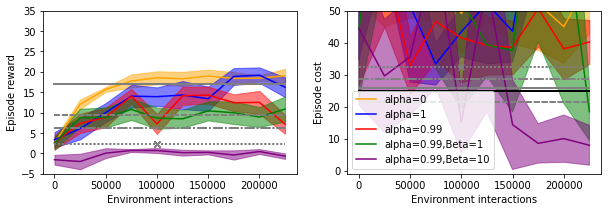

In [9]:
plot(["td3_an01_ss10k","td3_ss10k_m0","td3_ss10k_m001","td3_ss10k_m001_a1","td3_ss10k_m001_a10"],legend=["alpha=0","alpha=1","alpha=0.99","alpha=0.99,Beta=1","alpha=0.99,Beta=10"])

plt.show()


0.8769325046392344
94.48
3.367171758805623
38.72
-0.2814536702496233
18.2
0.9184155882399533
12.12


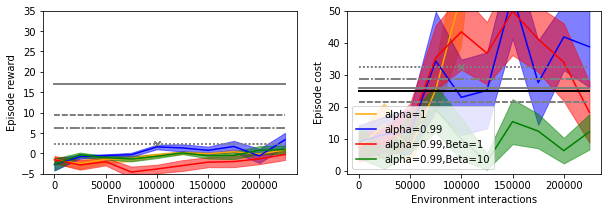

In [250]:
plot(["ppo_m0","ppo_m001","ppo_m001_a1","ppo_m001_a10"],legend=["alpha=1","alpha=0.99","alpha=0.99,Beta=1","alpha=0.99,Beta=10"])

plt.show()

rews [0.33533766 0.69258539 3.29034633 4.63307376 6.4847105  2.70566334
 4.87089952 6.38598093 7.053651   7.46138785]
costs [86.08 77.6  75.96 67.72 75.4  87.88 52.12 36.52 48.52 22.56]
7.461387852186733
22.56
rews [-5.64467321  1.07802139  2.62234241  4.96187989  2.96222294  2.92132271
  2.9911479   4.04160098  3.4526209   4.67885544]
costs [41.48 61.72 40.52 44.56 17.32 35.16 16.36 18.6  11.8  25.12]
4.678855436024196
25.12
rews [ 0.43077149 -1.03733185 -1.02350391 -0.20739836  1.08489421  0.10353693
 -0.29329094 -0.47477869 -0.74436887 -0.62868674]
costs [39.72 47.2  20.12 16.08 10.   21.72  6.8  10.08 10.28  5.  ]
-0.6286867373282141
5.0


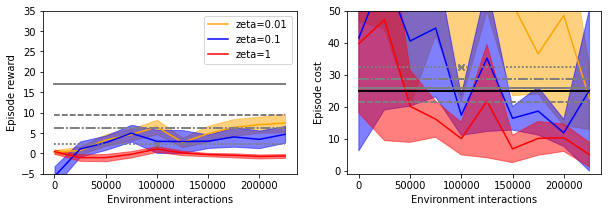

rews [ 2.59166068  9.6799957  10.78282271 10.99078569  8.84263464 10.12463651
 10.80490289  9.809702   10.77148229  6.98292003 11.00808576 10.14311831
 13.27871966 11.54801083 10.62432072  7.20417455 10.95446313 11.01367443
 10.8883588  11.21932597]
costs [58.48 73.84 59.2  43.84 36.24 25.2  23.16 42.24 27.8  35.24 20.8  19.56
 20.92 21.72 27.52 24.24 18.96 19.72 21.04 21.16]
11.21932597273637
21.16
rews [0.72264436 4.89482373 5.03988374 6.32556662 5.49123132 5.03826454
 5.05170132 5.87817483 4.04266302 2.86742642 4.4047819  6.16599413
 3.48065083 3.12056841 4.93527055 2.84260002 3.19766338 4.05071604
 4.35724354 4.61691292]
costs [38.84 19.2  49.92 74.84 39.36 27.68 22.76 23.36 24.96  8.24 13.52  6.88
 35.56  8.04  8.36  7.12 14.12  5.96  6.24 44.08]
4.616912919415241
44.08
rews [-1.87481764 -2.9127932  -0.96739564 -2.44353718 -2.19342791 -2.20429777
 -0.46409252 -2.10448229 -4.04462468 -2.22453305 -1.31934313 -1.31854433
 -0.12715339 -1.40051237 -0.56392473 -1.18817353 -0.80359516 -0

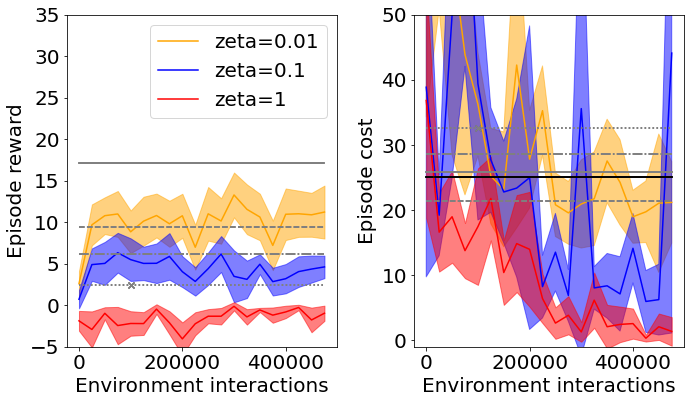

In [25]:
plot(["sac_c_ss10k_m001_a1_c001","sac_c_ss10k_m001_a1_c01","sac_c_ss10k_m001_a1_c1"],legend=["zeta=0.01","zeta=0.1","zeta=1"],loc_legend="upper right",fig_legend=1)

plt.show()

plot(["sac_c_ss10k_m001_a1_c001_long2","sac_c_ss10k_m001_a1_c01_long2","sac_c_ss10k_m001_a1_c1_long2"],legend=["zeta=0.01","zeta=0.1","zeta=1"],loc_legend="upper right",fig_legend=1,epochs=20,figsize=(10,6),fontsize=20)
plt.tight_layout()
plt.show()

0.042137355110753436
96.96
1.0771723269068358
62.56
-0.030056103639621343
97.0


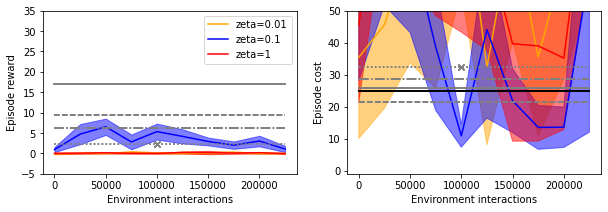

In [252]:
plot(["td3_ss10k_m001_a1_c001","td3_ss10k_m001_a1_c01","td3_ss10k_m001_a1_c1"],legend=["zeta=0.01","zeta=0.1","zeta=1"],loc_legend="upper right",fig_legend=1)

plt.show()

2.5637302375494886
18.4
0.0011515747272877873
16.64
0.08545455220487447
3.88


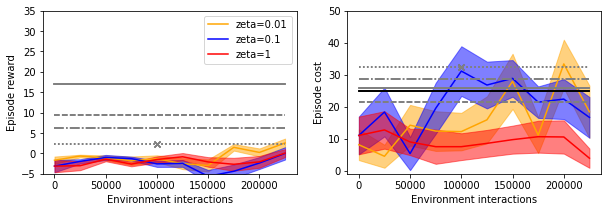

In [253]:
plot(["ppo_m001_a1_c001","ppo_m001_a1_c01","ppo_m001_a1_c1"],legend=["zeta=0.01","zeta=0.1","zeta=1"],loc_legend="upper right",fig_legend=1)

plt.show()

7.461387852186733
22.56
-0.40830507757551254
75.24
11.247733678517081
24.24
10.530043850470625
39.32
7.015737891762293
28.04


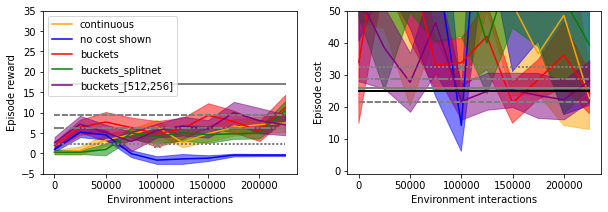

In [254]:
plot(["sac_c_ss10k_m001_a1_c001","sac_c_ss10k_m001_a1_c001_nocostinfo","sac_c_ss10k_m001_a1_c001_buckets","sac_c_ss10k_m001_a1_c001_buckets_splitnet","sac_c_ss10k_m001_a1_c001_buckets_first_layer_512"],legend=["continuous","no cost shown","buckets","buckets_splitnet","buckets_[512,256]"],fig_legend=1,loc_legend="upper left")

plt.show()

0.042137355110753436
96.96
1.9564290664162025
74.64
7.25292699972934
87.56
8.595090027175173
51.84
0.0421395540436351
96.96


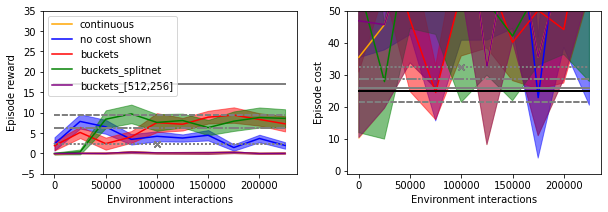

In [255]:
plot(["td3_ss10k_m001_a1_c001","td3_ss10k_m001_a1_c001_nocostinfo","td3_ss10k_m001_a1_c001_buckets","td3_ss10k_m001_a1_c001_buckets_splitnet","td3_ss10k_m001_a1_c001_buckets_first_layer_512"],legend=["continuous","no cost shown","buckets","buckets_splitnet","buckets_[512,256]"],fig_legend=1,loc_legend="upper left")

plt.show()

2.5637302375494886
18.4
4.961112411097046
37.28
3.2975834292455186
49.44
0.025425838898624063
35.32
0.6467788876110501
70.76


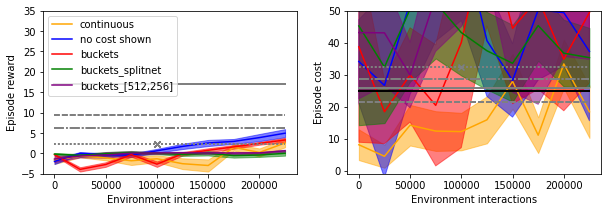

In [256]:
plot(["ppo_m001_a1_c001","ppo_m001_a1_c001_nocostinfo","ppo_m001_a1_c001_buckets","ppo_m001_a1_c001_buckets_splitnet","ppo_m001_a1_c001_buckets_first_layer_512"],legend=["continuous","no cost shown","buckets","buckets_splitnet","buckets_[512,256]"],fig_legend=1,loc_legend="upper left")

plt.show()

7.461387852186733
22.56
-7.523372740628832
31.36
9.755244730069586
41.12
6.28803409247037
16.08
-1.4257243042468324
5.16


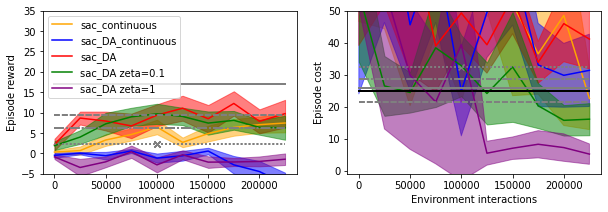

In [257]:
plot(["sac_c_ss10k_m001_a1_c001","sac_c_ss10k_m001_a1_c001_data_aug_nobuckets","sac_c_ss10k_m001_a1_c001_data_aug","sac_c_ss10k_m001_a1_c01_data_aug","sac_c_ss10k_m001_a1_c1_data_aug"],legend=["sac_continuous","sac_DA_continuous","sac_DA","sac_DA zeta=0.1","sac_DA zeta=1"],fig_legend=1,loc_legend="upper left")

plt.show()

7.461387852186733
22.56
7.365968905944918
11.6
3.7023290530455966
27.8
0.5210840002733462
37.0


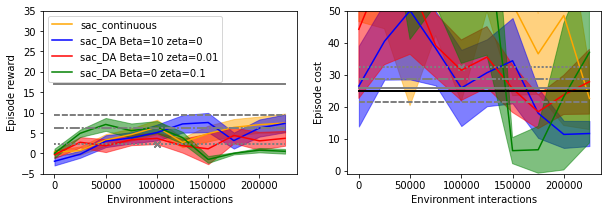

In [258]:
plot(["sac_c_ss10k_m001_a1_c001","sac_c_ss10k_m001_a10_data_aug","sac_c_ss10k_m001_a10_c001_data_aug","sac_c_ss10k_m001_a0_c01_data_aug"],["sac_continuous","sac_DA Beta=10 zeta=0","sac_DA Beta=10 zeta=0.01","sac_DA Beta=0 zeta=0.1"],fig_legend=1,loc_legend="upper left")


plt.show()

6.505074035029721
44.6
16.568623529300524
67.16
nan
nan
9.227762253839895
31.48
-0.4099426051034717
19.68


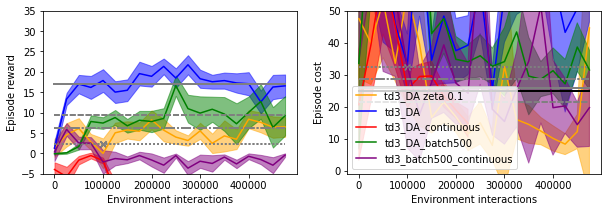

In [259]:
plot(["td3_ss10k_m001_a1_c01_long_data_aug","td3_ss10k_m001_a1_c001_long_data_aug","td3_ss10k_m001_a1_c001_data_aug_nobuckets","td3_ss10k_m001_a1_c001_long_data_aug_bigbatch","td3_ss10k_m001_a1_c001_long_bigbatch"],legend=["td3_DA zeta 0.1","td3_DA","td3_DA_continuous","td3_DA_batch500","td3_batch500_continuous"],epochs=20)
plt.show()

8.498865499848005
19.08
15.03801649679415
53.52
-0.5620921673886796
8.76
9.51174899434528
34.24


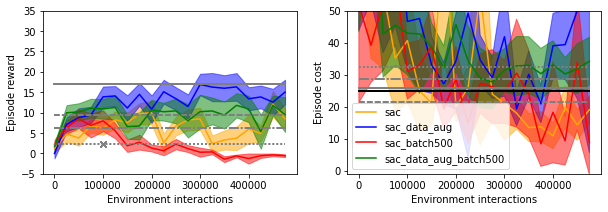

In [260]:
plot(["sac_c_ss10k_m001_a1_c001_long","sac_c_ss10k_m001_a1_c001_long_data_aug","sac_c_ss10k_m001_a1_c001_long_bigbatch_correct","sac_c_ss10k_m001_a1_c001_long_data_bigbatch"],legend=["sac","sac_data_aug","sac_batch500","sac_data_aug_batch500"],epochs=20)

plt.show()

rews [ 1.1573012   4.76144525  3.76520082  6.7817053   6.21334342  8.26596115
  7.57058067  9.75147789  9.99619958  2.53169312  6.6859347   8.22015108
  8.44941497  2.3817739   3.28044539  3.7200721   5.94828384  4.90134256
 12.09641879  8.4988655 ]
costs [113.96  71.48  56.32  35.16  40.68  25.04  21.04  77.24  20.    25.88
  55.12  23.88  21.    17.96  13.44  13.72  10.88  19.8   14.28  19.08]
8.498865499848005
19.08
rews [1.08564486 5.39567024 1.7474534  5.1183055  4.77091904 4.54961484
 5.58298128 3.2675066  7.3711071  3.50250437 5.07745026 3.34747384
 4.98904042 3.92753025 3.9348922  3.08253329 3.64256902 3.25834541
 2.66168069 0.995993  ]
costs [78.72 48.16 69.92 44.24 34.96 18.04 11.24 42.96 78.88 55.84 41.32 48.52
 21.36 13.16 31.4  32.96  7.48  7.6  15.32 12.24]
0.995992997246214
12.24
rews [-1.39089345e-02  7.11984503e+00  8.79694521e+00  9.42137759e+00
  1.38722914e+01  1.40980914e+01  1.11414138e+01  1.44816413e+01
  1.08517551e+01  1.51284321e+01  1.34289768e+01  1.1507967

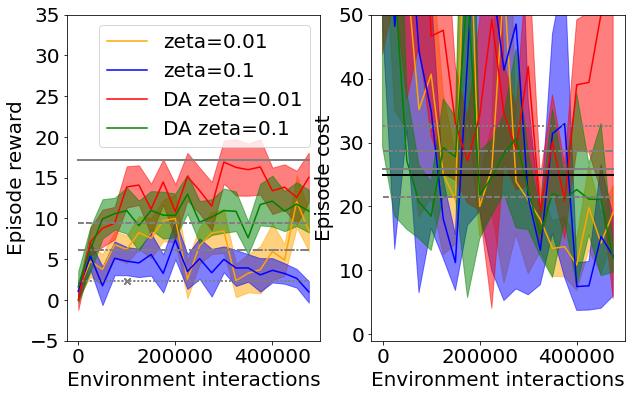

In [29]:
plot(["sac_c_ss10k_m001_a1_c001_long","sac_c_ss10k_m001_a1_c01_long","sac_c_ss10k_m001_a1_c001_long_data_aug","sac_c_ss10k_m001_a1_c01_long_data_aug"],legend=["zeta=0.01","zeta=0.1","DA zeta=0.01","DA zeta=0.1"], epochs=20,loc_legend="upper right",fig_legend=1,figsize=(10,6),fontsize=20)#,figsize=(10,6),fontsize=20)

plt.show()

25.381989760486537
45.96
17.673822141409033
77.48
5.657279887228066
26.52


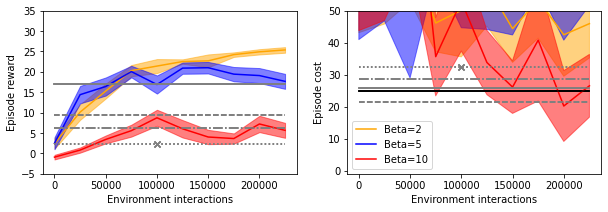

1.8911188506839545
1.16
5.197189222960423
21.24
8.498865499848005
19.08
0.995992997246214
12.24
1.3594713662800766
4.16


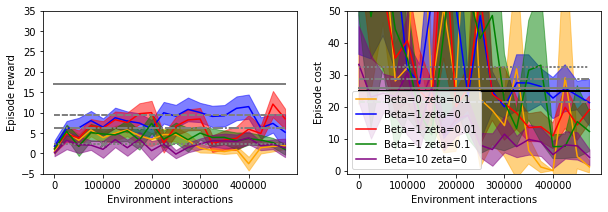

In [262]:
plot(["sac_c_ss10k_m1_a2","sac_c_ss10k_m1_a5","sac_c_ss10k_m1_a10"],legend=["Beta=2","Beta=5","Beta=10"])
plt.show()


plot(["sac_c_ss10k_m001_a0_c01_long","sac_c_ss10k_m001_a1_long","sac_c_ss10k_m001_a1_c001_long","sac_c_ss10k_m001_a1_c01_long","sac_c_ss10k_m001_a10_long"],legend=["Beta=0 zeta=0.1","Beta=1 zeta=0","Beta=1 zeta=0.01","Beta=1 zeta=0.1","Beta=10 zeta=0"],epochs=20)
plt.show()



0.34512648116841177
4.96
4.39680012699646
7.36
7.930545954249344
24.8


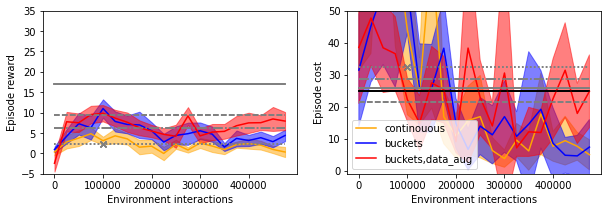

In [263]:
plot(["sac_c_ss10k_m1_a10_long","sac_c_ss10k_m1_a10_buckets_long","sac_c_ss10k_m1_a10_buckets_data_aug_long"],legend=["continouous","buckets","buckets,data_aug"],epochs=20)
plt.show()

12.772642263783801
24.12
1.9068860509770473
164.96
15.273115421794396
32.76
10.003008276611482
29.28
-0.30479660443640194
39.36


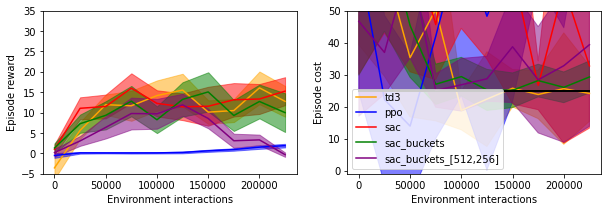

11.793995644775903
14.36
16.83681103216452
103.04
15.838510961111048
81.44
12.193824525323514
11.96
5.904205778711364
14.76


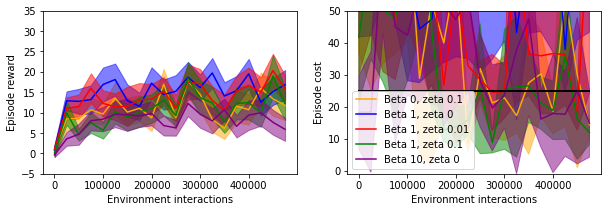

32.00030704855074
65.6
31.191531444631014
64.76
13.857032401547752
82.0


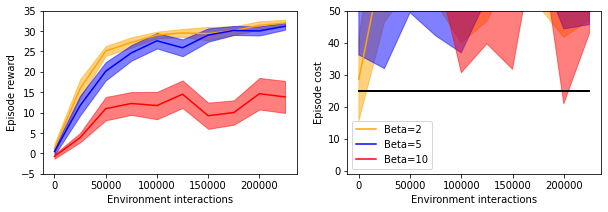

In [264]:
plot(["td3_ss10k_m001_a1_c001_cargoal","ppo_m001_a1_c001_cargoal","sac_c_ss10k_m001_a1_c001_cargoal","sac_c_ss10k_m001_a1_c001_buckets_cargoal","sac_c_ss10k_m001_a1_c001_buckets_first_layer_512_cargoal"],legend=["td3","ppo","sac","sac_buckets","sac_buckets_[512,256]"])
plt.show()

plot(["sac_c_ss10k_m001_a0_c01_cargoal","sac_c_ss10k_m001_a1_cargoal","sac_c_ss10k_m001_a1_c001_cargoal","sac_c_ss10k_m001_a1_c01_cargoal","sac_c_ss10k_m001_a10_cargoal"],epochs=20,legend=["Beta 0, zeta 0.1","Beta 1, zeta 0", "Beta 1, zeta 0.01","Beta 1, zeta 0.1","Beta 10, zeta 0"])
plt.show()


plot(["sac_c_ss10k_m1_a2_cargoal","sac_c_ss10k_m1_a5_cargoal","sac_c_ss10k_m1_a10_cargoal"],legend=["Beta=2","Beta=5","Beta=10"])
plt.show()








10.163330020432966
32.68
nan
nan
15.51107116866269
14.12


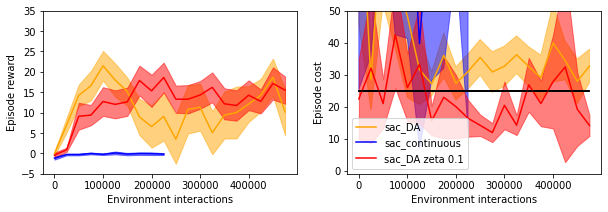

10.989446504192404
25.28
nan
nan
12.215772392685878
17.44


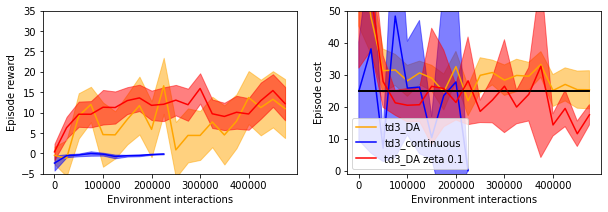

In [265]:

plot(["sac_c_ss10k_m001_a1_c001_long_data_aug_cargoal","sac_c_ss10k_m001_a1_c001_data_aug_cont_cargoal","sac_c_ss10k_m001_a1_c01_long_data_aug_cargoal"],legend=["sac_DA","sac_continuous","sac_DA zeta 0.1"],epochs=20)

plt.show()


plot(["td3_ss10k_m001_a1_c001_long_data_aug_cargoal","td3_ss10k_m001_a1_c001_data_aug_cont_cargoal","td3_ss10k_m001_a1_c01_long_data_aug_cargoal"],legend=["td3_DA","td3_continuous","td3_DA zeta 0.1"],epochs=20)
plt.show()


0.28884250051795357
43.72
0.5382568197809054
13.8
0.07195334546656962
5.68
-0.08604451567456013
4.32
-0.9731364195876919
27.68


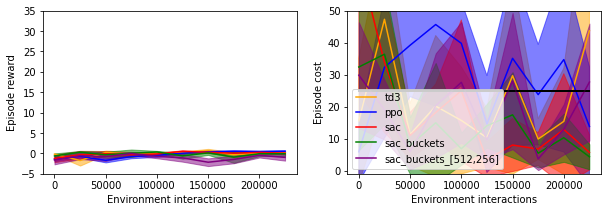

0.0037431277268225884
17.2
-0.026366022065251772
1.36
0.03191792404104854
0.64
-1.1608531410671319
0.44
0.078670306737635
0.0


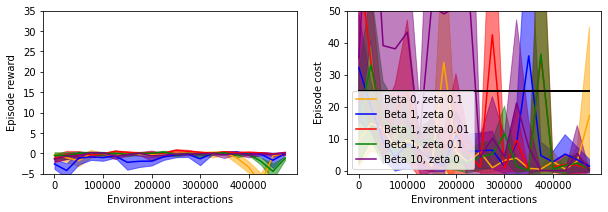

0.25719018626739065
23.64
0.4811646815232845
31.0
0.2009123361144459
2.6


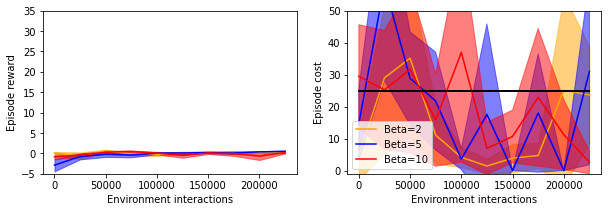

In [266]:
plot(["td3_ss10k_m001_a1_c001_pointpush","ppo_m001_a1_c001_pointpush","sac_c_ss10k_m001_a1_c001_pointpush","sac_c_ss10k_m001_a1_c001_buckets_pointpush","sac_c_ss10k_m001_a1_c001_buckets_first_layer_512_pointpush"],legend=["td3","ppo","sac","sac_buckets","sac_buckets_[512,256]"])

plt.show()

plot(["sac_c_ss10k_m001_a0_c01_pointpush","sac_c_ss10k_m001_a1_pointpush","sac_c_ss10k_m001_a1_c001_pointpush","sac_c_ss10k_m001_a1_c01_pointpush","sac_c_ss10k_m001_a10_pointpush"],legend=["Beta 0, zeta 0.1","Beta 1, zeta 0", "Beta 1, zeta 0.01","Beta 1, zeta 0.1","Beta 10, zeta 0"],epochs=20)
plt.show()

plot(["sac_c_ss10k_m1_a2_pointpush","sac_c_ss10k_m1_a5_pointpush","sac_c_ss10k_m1_a10_pointpush"],legend=["Beta=2","Beta=5","Beta=10"])
plt.show()

0.4408853761115506
3.44
nan
nan
-0.2729667439715002
3.76


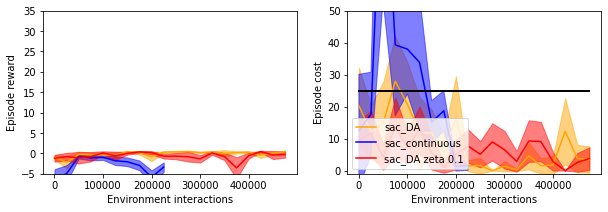

0.18567756764757193
2.68
nan
nan
0.025077726476088313
3.4


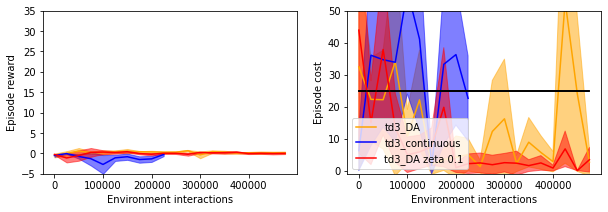

In [267]:

plot(["sac_c_ss10k_m001_a1_c001_long_data_aug_pointpush","sac_c_ss10k_m001_a1_c001_data_aug_cont_pointpush","sac_c_ss10k_m001_a1_c01_long_data_aug_pointpush"],legend=["sac_DA","sac_continuous","sac_DA zeta 0.1"],epochs=20)

plt.show()


plot(["td3_ss10k_m001_a1_c001_long_data_aug_pointpush","td3_ss10k_m001_a1_c001_data_aug_cont_pointpush","td3_ss10k_m001_a1_c01_long_data_aug_pointpush"],legend=["td3_DA","td3_continuous","td3_DA zeta 0.1"],epochs=20)
plt.show()


0.5392158200964097
26.12
1.6697092812707037
126.12
-1.7113556285920426
30.92
-2.0118485144055236
30.68
-1.9517442770718159
65.68


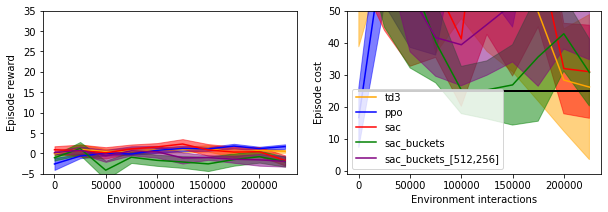

-0.12800988643361444
94.08
2.7616303835017497
86.44
0.9883486877088022
29.36
-0.144679982621964
5.32
-2.8232146911870877
12.76


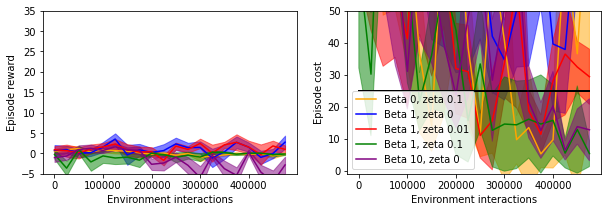

20.5612924560646
177.8
2.3826973411875194
29.44
0.1159945699409524
46.36


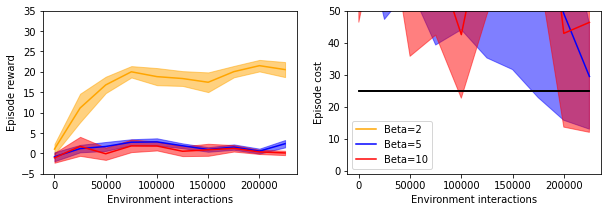

In [268]:
plot(["td3_ss10k_m001_a1_c001_pointgoal2","ppo_m001_a1_c001_pointgoal2","sac_c_ss10k_m001_a1_c001_pointgoal2","sac_c_ss10k_m001_a1_c001_buckets_pointgoal2","sac_c_ss10k_m001_a1_c001_buckets_first_layer_512_pointgoal2"],legend=["td3","ppo","sac","sac_buckets","sac_buckets_[512,256]"])

plt.show()

plot(["sac_c_ss10k_m001_a0_c01_pointgoal2","sac_c_ss10k_m001_a1_pointgoal2","sac_c_ss10k_m001_a1_c001_pointgoal2","sac_c_ss10k_m001_a1_c01_pointgoal2","sac_c_ss10k_m001_a10_pointgoal2"],legend=["Beta 0, zeta 0.1","Beta 1, zeta 0", "Beta 1, zeta 0.01","Beta 1, zeta 0.1","Beta 10, zeta 0"],epochs=20)
plt.show()

plot(["sac_c_ss10k_m1_a2_pointgoal2","sac_c_ss10k_m1_a5_pointgoal2","sac_c_ss10k_m1_a10_pointgoal2"],legend=["Beta=2","Beta=5","Beta=10"])
plt.show()


3.51655138426751
62.2
nan
nan
0.16761499209019817
8.88


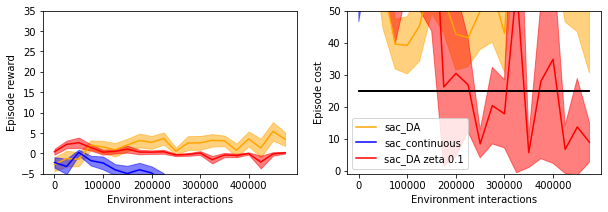

-6.062055580821732
51.08
nan
nan
-0.22112932461473
0.68


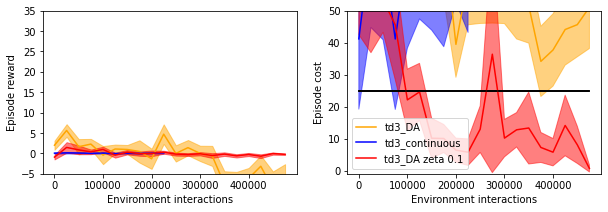

In [269]:

plot(["sac_c_ss10k_m001_a1_c001_long_data_aug_pointgoal2","sac_c_ss10k_m001_a1_c001_data_aug_cont_pointgoal2","sac_c_ss10k_m001_a1_c01_long_data_aug_pointgoal2"],legend=["sac_DA","sac_continuous","sac_DA zeta 0.1"],epochs=20)

plt.show()


plot(["td3_ss10k_m001_a1_c001_long_data_aug_pointgoal2","td3_ss10k_m001_a1_c001_data_aug_cont_pointgoal2","td3_ss10k_m001_a1_c01_long_data_aug_pointgoal2"],legend=["td3_DA","td3_continuous","td3_DA zeta 0.1"],epochs=20)
plt.show()


rews [ 5.18630036  7.83378373  7.81323434  9.42835233 11.25775144  8.7420428
 10.42795526  9.54354785  9.60706872 10.61260774 11.31206258 12.28657187
 12.16951994 15.49495769 12.54033994 14.05675547 14.13072405 14.16913814
 13.60275086 13.44697288 14.31585793 14.9908417  13.19986391 15.02813785
 13.15700848 14.18884673 11.69341381 11.32648882 12.84049361 11.926971
 11.20375264  9.76724954 11.65369891 12.52891566 11.78388527 11.79863125
 13.14953381 13.74538934 11.05558212 12.81505768 12.61613691 10.15882753
 11.0965684  11.60898958 12.04269493 10.83676605 11.64751112  9.96697592
 12.44436007 12.96425694 11.50544181 10.74271452 11.48869472 10.22588117
 11.7984496  13.68088337 10.58012073  9.65150915 10.07710538 10.87145283
 11.76318472 11.72204443 11.36697228 10.21546833 11.66631207 11.38181773
 10.36026403 11.88018209 11.4275732  12.09428337 12.98429819 10.69136388
 12.64233729 11.44840231 12.05743261 15.40002485 13.13575538 14.42704773
 13.27990773 14.16386401 12.15712316 10.16374235 

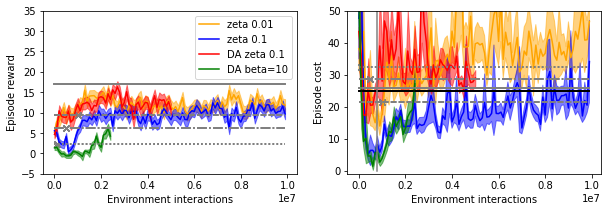

rews [ 0.14358938  0.00163419 -0.06499158  0.03180293 -0.03478643 -0.04141488
 -0.05482336 -0.08273217  0.04318682  0.00849818  0.05742633  0.0469149
  0.1094398   0.03665764  0.0476075   0.05324004 -0.02153346  0.02793435
 -0.01959858  0.01644771 -0.03739841  0.03030536  0.04122535  0.15099008
  0.13019986  0.09989157  0.08046916  0.03005932  0.01907891  0.05356209
 -0.01640323 -0.0738268  -0.08693481 -0.10530781  0.11015912  0.01303377
  0.1092491   0.02651687  0.0738763  -0.02202265  0.15654955 -0.00047764
 -0.09207639 -0.02989458 -0.04907942  0.04180762 -0.02330372 -0.02764887
  0.0209098   0.04567998]
costs [58.86 72.53 66.33 72.34 67.9  44.38 75.09 61.5  60.39 73.08 73.96 70.42
 54.99 61.5  75.29 73.54 64.91 74.14 60.88 67.26 55.35 50.55 80.27 79.33
 84.42 65.52 58.24 76.2  49.51 67.01 58.77 50.6  49.27 58.09 77.24 74.76
 52.94 56.01 52.6  65.33 53.96 72.21 39.96 49.08 54.84 64.54 61.09 55.72
 76.3  58.95]
0.045679981516962176
58.95


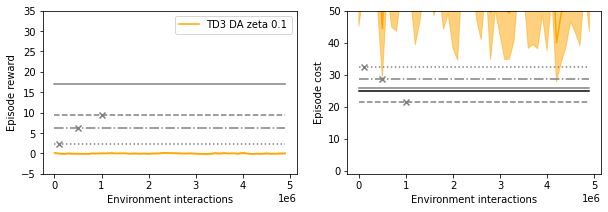

In [26]:
plot(["sac_c_ss10k_m001_a1_c001_10M","sac_c_ss10k_m001_a1_c01_10M","sac_c_ss10k_m001_a1_c01_data_aug_5M","sac_c_ss10k_m001_a10_data_aug_2_5M"],epochs=400,legend=["zeta 0.01","zeta 0.1","DA zeta 0.1","DA beta=10"],stretch=4,fig_legend=1,loc_legend="upper right")
plt.plot([800000,800000],[0,50],"grey")
plt.show()


plot(["td3_ss10k_m001_a1_c01_data_aug_5M"],epochs=200,legend=["TD3 DA zeta 0.1"],stretch=4,fig_legend=1,loc_legend="upper right")

In [271]:
print()